In [10]:
import os
import pandas as pd
import xml.etree.ElementTree as ET

# data path
train_dir = r'C:\Users\xiaog\Desktop\Project\Datasets\dataset\split_80_10_10\train'
valid_dir = r'C:\Users\xiaog\Desktop\Project\Datasets\dataset\split_80_10_10\valid'
test_dir = r'C:\Users\xiaog\Desktop\Project\Datasets\dataset\split_80_10_10\test'

In [11]:
# get label
def get_label_from_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    objects = root.findall('object')

    # if exist "thermal_defect", return 1
    for obj in objects:
        if obj.find('name').text == 'thermal_defect':
            return "1"  

    return "0" 

# count defects
def count_defects_in_directory(data_dir):
    with_defect = 0
    without_defect = 0
    
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.xml'):
                xml_path = os.path.join(root, file)
                img_path = os.path.join(root.replace('annotations', 'images'), file.replace('.xml', '.jpg'))

                if os.path.exists(img_path):  
                    label = get_label_from_xml(xml_path)  
                    if label == "1":
                        with_defect += 1
                    else:
                        without_defect += 1
    
    return with_defect, without_defect

def create_dataframe(data_dir):
    data = []
    
    for root, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.xml'):
                xml_path = os.path.join(root, file)
                img_path = os.path.join(root.replace('annotations', 'images'), file.replace('.xml', '.jpg'))

                if os.path.exists(img_path):  
                    label = get_label_from_xml(xml_path) 
                    data.append([img_path, label])
    
    return pd.DataFrame(data, columns=['filepath', 'label'])

train_df = create_dataframe(train_dir)
valid_df = create_dataframe(valid_dir)
test_df = create_dataframe(test_dir)

print(f"Train set: {len(train_df)} images")
print(f"Valid set: {len(valid_df)} images")
print(f"Test set: {len(test_df)} images")

train_with_defect, train_without_defect = count_defects_in_directory(train_dir)
valid_with_defect, valid_without_defect = count_defects_in_directory(valid_dir)
test_with_defect, test_without_defect = count_defects_in_directory(test_dir)

print(f"Train set - defect: {train_with_defect}, no_defect: {train_without_defect}")
print(f"Valid set - defect: {valid_with_defect}, no_defect: {valid_without_defect}")
print(f"Test set - defect: {test_with_defect}, no_defect: {test_without_defect}")


Train set: 4281 images
Valid set: 535 images
Test set: 536 images
Train set - defect: 3790, no_defect: 491
Valid set - defect: 466, no_defect: 69
Test set - defect: 477, no_defect: 59


Class distribution saved at: C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\split_80_10_10\class_distribution_split_80_10_10.png


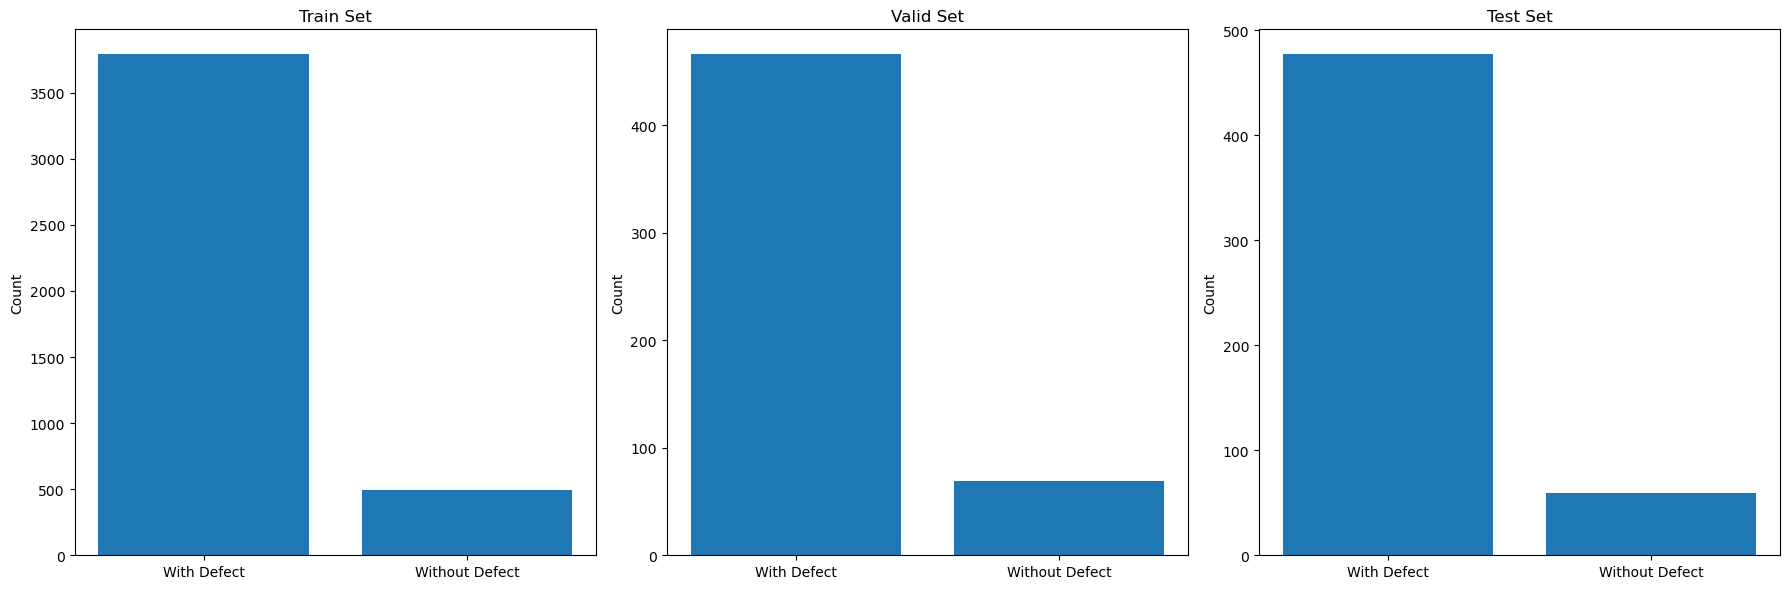

In [11]:
import matplotlib.pyplot as plt

def plot_class_distribution(ax, with_defect, without_defect, title):
    ax.bar(['With Defect', 'Without Defect'], [with_defect, without_defect])
    ax.set_title(title)
    ax.set_ylabel('Count')

# Create a figure and set up subplots (1 row, 3 columns)
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot for Train Set
plot_class_distribution(axs[0], train_with_defect, train_without_defect, 'Train Set')

# Plot for Valid Set
plot_class_distribution(axs[1], valid_with_defect, valid_without_defect, 'Valid Set')

# Plot for Test Set
plot_class_distribution(axs[2], test_with_defect, test_without_defect, 'Test Set')

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure
save_dir = r"C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\split_80_10_10"
class_distribution_path = os.path.join(save_dir, 'class_distribution_split_80_10_10.png')
plt.savefig(class_distribution_path, dpi=600, bbox_inches='tight')

# Print the saved path
print(f"Class distribution saved at: {class_distribution_path}")

# Show the plot
plt.show()


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

train_datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=30,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True 
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

# train generator
train_generator_80_10_10 = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="filepath",
    y_col="label",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical"  
)

# valid generator
valid_generator_80_10_10 = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col="filepath",
    y_col="label",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical"
)

# test generator
test_generator_80_10_10 = valid_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="filepath",
    y_col="label",
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False  
)

print(f"Train generator samples: {train_generator_80_10_10.samples}")
print(f"Valid generator samples: {valid_generator_80_10_10.samples}")
print(f"Test generator samples: {test_generator_80_10_10.samples}")

Found 4281 validated image filenames belonging to 2 classes.
Found 535 validated image filenames belonging to 2 classes.
Found 536 validated image filenames belonging to 2 classes.
Train generator samples: 4281
Valid generator samples: 535
Test generator samples: 536


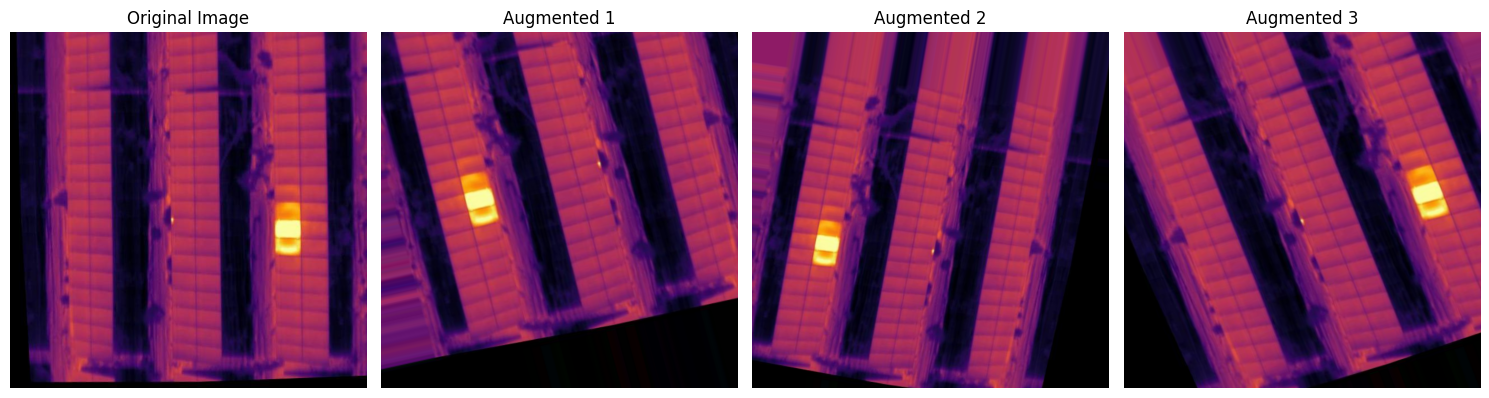

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

image_path = r"C:\Users\xiaog\Desktop\Project\Datasets\dataset\split_80_10_10\train\images\test_0193.jpg"
original_image = load_img(image_path, target_size=(640, 640))  
original_image = img_to_array(original_image)  
original_image = np.expand_dims(original_image, axis=0)  

augmented_images = train_datagen.flow(original_image, batch_size=1)
augmented_image_1 = next(augmented_images)[0]
augmented_image_2 = next(augmented_images)[0]
augmented_image_3 = next(augmented_images)[0]

save_dir = r"C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\split_80_10_10"
os.makedirs(save_dir, exist_ok=True)

for i, aug_img in enumerate([augmented_image_1, augmented_image_2, augmented_image_3], start=1):
    save_path = os.path.join(save_dir, f"augmented_image_{i}.jpg")
    img = Image.fromarray(np.uint8(np.clip(aug_img * 255, 0, 255)))  
    img.save(save_path)

plt.figure(figsize=(15, 5))

plt.subplot(1, 4, 1)
plt.imshow(original_image[0] / 255.0)  
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(augmented_image_1)
plt.title('Augmented 1')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(augmented_image_2)
plt.title('Augmented 2')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(augmented_image_3)
plt.title('Augmented 3')
plt.axis('off')

plt.tight_layout()
plt.show()

from PIL import ImageDraw, ImageFont


image_list = [original_image[0] / 255.0, augmented_image_1, augmented_image_2, augmented_image_3]
image_list = [np.uint8(np.clip(img * 255, 0, 255)) for img in image_list]


img_height, img_width = image_list[0].shape[:2]
title_height = 40 


combined_width = img_width * 4
combined_height = img_height + title_height
combined_image = Image.new("RGB", (combined_width, combined_height), color=(255, 255, 255))


try:
    font = ImageFont.truetype("arial.ttf", 24)
except:
    font = ImageFont.load_default()

draw = ImageDraw.Draw(combined_image)
titles = ["Original Image", "Augmented 1", "Augmented 2", "Augmented 3"]

for i, (img_arr, title) in enumerate(zip(image_list, titles)):
    img_pil = Image.fromarray(img_arr)
    combined_image.paste(img_pil, (i * img_width, title_height)) 
    text_x = i * img_width + 10
    draw.text((text_x, 10), title, fill=(0, 0, 0), font=font)    

save_path_combined = os.path.join(save_dir, "combined_augmented_image_with_titles.jpg")
combined_image.save(save_path_combined)

In [15]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf

def inception_module(x, filters):
    # 1x1 Conv
    conv1x1 = Conv2D(filters, (1,1), padding='same', activation='relu')(x)
    
    # 3x3 Conv
    conv3x3 = Conv2D(filters, (3,3), padding='same', activation='relu')(x)
    
    # 5x5 Conv
    conv5x5 = Conv2D(filters, (5,5), padding='same', activation='relu')(x)
    
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pool = Conv2D(filters, (1,1), padding='same', activation='relu')(pool)
    
    merged = concatenate([conv1x1, conv3x3, conv5x5, pool], axis=-1)
    return merged

def attention_block(inputs):
    attention = Dense(1, activation='tanh')(inputs)    # (batch_size, seq_length, 1)
    attention = Flatten()(attention)                   # (batch_size, seq_length)
    attention = Activation('softmax')(attention)       # (batch_size, seq_length)
    attention = Reshape((inputs.shape[1], 1))(attention)  # (batch_size, seq_length, 1)
    
    context = Multiply()([inputs, attention])          # (batch_size, seq_length, features)
    return context


def build_model(input_shape=(128, 128, 3), num_classes=2):
    inputs = Input(shape=input_shape)
    x = inception_module(inputs, 32)
    x = MaxPooling2D(2)(x)
    x = inception_module(x, 64)
    x = MaxPooling2D(2)(x)
    x = inception_module(x, 128)
    x = GlobalAveragePooling2D()(x)

    x = Reshape((-1, 128))(x)  # sequence for LSTM
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = attention_block(x)
    x = GlobalAveragePooling1D()(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model
    # Build the model
model = build_model(input_shape=(128, 128, 3), num_classes=2)

# Print the model summary
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  128         ['input_1[0][0]']                
                                )                                                                 
                                                                                              

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

def focal_loss(gamma=2., alpha=0.75):
    """
    Focal Loss implementation for binary classification.

    Parameters:
        gamma (float): Focusing parameter. Default is 2.
        alpha (float): Weighting factor for class imbalance. Default is 0.75 for better focusing on less frequent class.

    Returns:
        loss (function): Focal loss function.
    """

    def focal_loss_fixed(y_true, y_pred):
        # Clip predictions to avoid log(0)
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())

        # Calculate cross entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate modulating factor (1 - p_t) ^ gamma
        modulating_factor = K.pow(1 - y_pred, gamma)

        # Calculate the focal loss
        loss = alpha * modulating_factor * cross_entropy

        return K.sum(loss, axis=-1)

    return focal_loss_fixed

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


def compile_model(model, split_name="split_80_10_10"):
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss=focal_loss(gamma=2., alpha=0.75),
        metrics=[
            'accuracy', 
            Precision(name='precision'), 
            Recall(name='recall'), 
            'AUC']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ModelCheckpoint(
            filepath=f'models/best_model_{split_name}.h5',
            monitor='val_loss',
            save_best_only=True,
            mode='min',
            verbose=1
        ),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)
    ]

    return callbacks

In [19]:
import pickle
import numpy as np 

def train_and_save_history(train_generator, valid_generator, split_name="split_80_10_10", epochs=50, batch_size=32):
    steps_per_epoch = train_generator.samples // batch_size
    validation_steps = valid_generator.samples // batch_size

   # compile model
    model = build_model() 

    callbacks = compile_model(model, split_name)

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_generator,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=callbacks
    )

    # save history
    history_path = f"models/history_{split_name}.pkl"
    with open(history_path, 'wb') as f:  
        pickle.dump(history.history, f)

    print(f"Train history for {split_name} saved as {history_path}")


# train `split_80_10_10` and save history
train_and_save_history(train_generator_80_10_10, valid_generator_80_10_10, split_name="split_80_10_10")

Epoch 1/50
133/133 [==============================] - ETA: 0s - loss: 0.0803 - accuracy: 0.8795 - precision: 0.8795 - recall: 0.8795 - auc: 0.8891
Epoch 1: val_loss improved from inf to 0.07632, saving model to models\best_model_split_80_10_10.h5
133/133 [==============================] - 141s 815ms/step - loss: 0.0803 - accuracy: 0.8795 - precision: 0.8795 - recall: 0.8795 - auc: 0.8891 - val_loss: 0.0763 - val_accuracy: 0.8672 - val_precision: 0.8672 - val_recall: 0.8672 - val_auc: 0.8870 - lr: 1.0000e-04
Epoch 2/50
133/133 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.8859 - precision: 0.8859 - recall: 0.8859 - auc: 0.9039
Epoch 2: val_loss improved from 0.07632 to 0.07308, saving model to models\best_model_split_80_10_10.h5
133/133 [==============================] - 105s 789ms/step - loss: 0.0708 - accuracy: 0.8859 - precision: 0.8859 - recall: 0.8859 - auc: 0.9039 - val_loss: 0.0731 - val_accuracy: 0.8672 - val_precision: 0.8672 - val_recall: 0.8672 - val

Accuracy curve saved at: C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\split_80_10_10\accuracy_curve_split_80_10_10.png
Loss curve saved at: C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\split_80_10_10\loss_curve_split_80_10_10.png


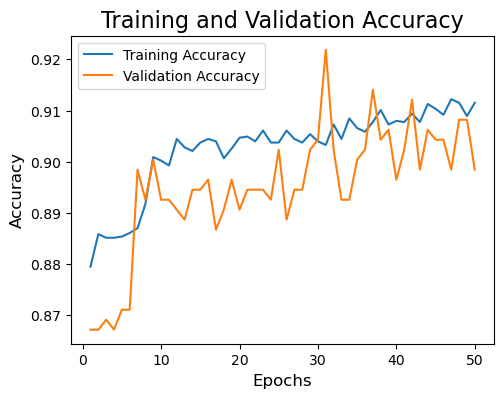

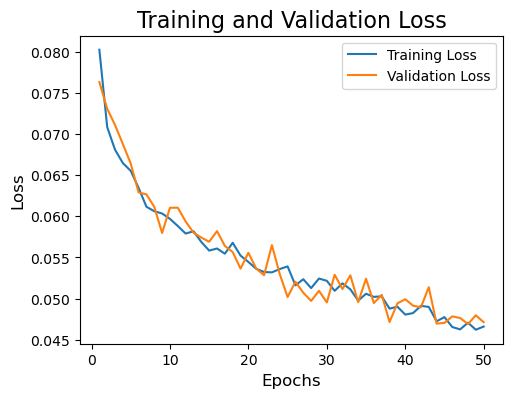

In [20]:
import matplotlib.pyplot as plt
import pickle
import os

# load history
history_path = "models/history_split_80_10_10.pkl"  
with open(history_path, 'rb') as f:
    history = pickle.load(f)
    
# Plot training and validation loss and acc
acc = history['accuracy']
val_acc = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)

# Define the directory to save the image
save_dir = r"C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\split_80_10_10"
os.makedirs(save_dir, exist_ok=True)  # Ensure the directory exists

plt.figure(figsize=(12, 4))
# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
accuracy_path = os.path.join(save_dir, 'accuracy_curve_split_80_10_10.png')
plt.savefig(accuracy_path, dpi=600, bbox_inches='tight')
print(f"Accuracy curve saved at: {accuracy_path}")


# Plot training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
loss_path = os.path.join(save_dir, 'loss_curve_split_80_10_10.png')
plt.savefig(loss_path, dpi=600, bbox_inches='tight')
print(f"Loss curve saved at: {loss_path}")

plt.show()


Precision and Recall curve saved at: C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\split_80_10_10\precision_recall_curve_split_80_10_10.png


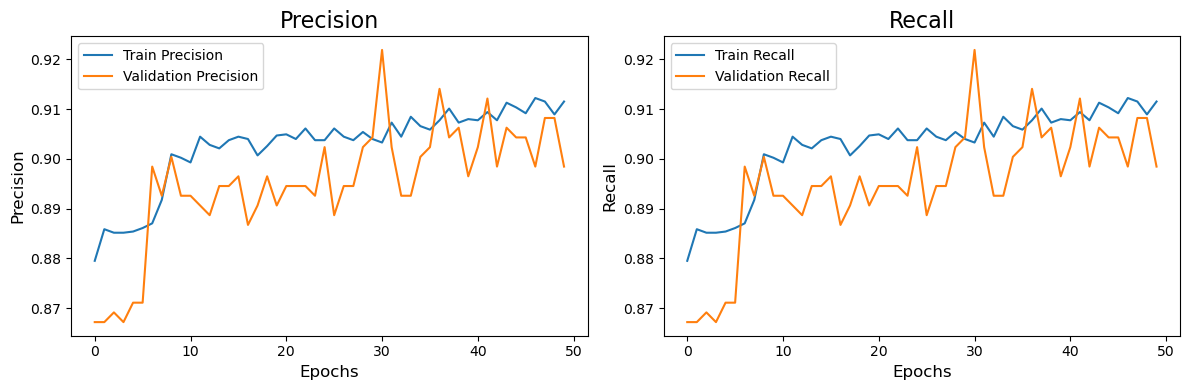

In [21]:
import matplotlib.pyplot as plt
import pickle

# load history
history_path = 'models/history_split_80_10_10.pkl'  
with open(history_path, 'rb') as f:
    history_dict = pickle.load(f)

def plot_precision_recall(history):
    if 'precision' not in history or 'recall' not in history:
        print("No precision or recall data found in history!")
        return

    save_dir = r"C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\split_80_10_10"
    os.makedirs(save_dir, exist_ok=True)  
    
    plt.figure(figsize=(12, 4))
    
    # Precision plot
    plt.subplot(1, 2, 1)
    plt.plot(history['precision'], label='Train Precision')
    plt.plot(history['val_precision'], label='Validation Precision')
    plt.title('Precision', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.legend()

    # Recall plot
    plt.subplot(1, 2, 2)
    plt.plot(history['recall'], label='Train Recall')
    plt.plot(history['val_recall'], label='Validation Recall')
    plt.title('Recall', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Recall', fontsize=12)
    plt.legend()

    plt.tight_layout()

    # Save the figure
    precision_recall_path = os.path.join(save_dir, 'precision_recall_curve_split_80_10_10.png')
    plt.savefig(precision_recall_path, dpi=600, bbox_inches='tight')
    print(f"Precision and Recall curve saved at: {precision_recall_path}")
    
    plt.show()


plot_precision_recall(history_dict)

AUC curve saved at: C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\split_80_10_10\auc_curve_split_80_10_10.png


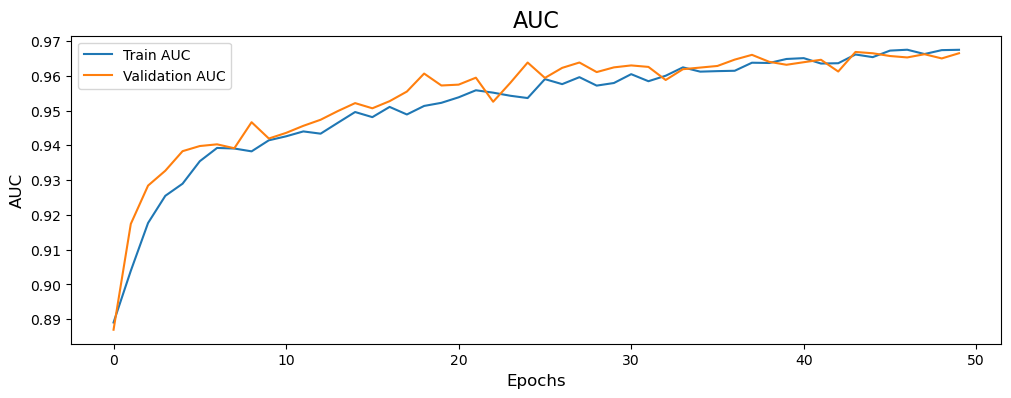

In [22]:
import matplotlib.pyplot as plt
import pickle

# load history
history_path = 'models/history_split_80_10_10.pkl' 
with open(history_path, 'rb') as f:
    history_dict = pickle.load(f)
    
def plot_auc(history):
    if 'auc' not in history or 'val_auc' not in history:
        print("No AUC data found in history!")
        return
    save_dir = r"C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\split_80_10_10"
    os.makedirs(save_dir, exist_ok=True) 
    
    plt.figure(figsize=(12, 4))

    # AUC plot
    plt.plot(history['auc'], label='Train AUC')
    plt.plot(history['val_auc'], label='Validation AUC')
    plt.title('AUC', fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('AUC', fontsize=12)
    plt.legend()

    auc_path = os.path.join(save_dir, 'auc_curve_split_80_10_10.png')
    plt.savefig(auc_path, dpi=600, bbox_inches='tight')
    print(f"AUC curve saved at: {auc_path}")

    plt.show()


plot_auc(history_dict)

In [25]:
from tensorflow.keras.models import load_model

# load model and loss function
model = load_model(
    'models/best_model_split_80_10_10.h5',
    custom_objects={'focal_loss_fixed': focal_loss(gamma=2., alpha=0.75)}  
)

# evaluation
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator_80_10_10, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")


17/17 [==============================] - 8s 250ms/step - loss: 0.0456 - accuracy: 0.9142 - precision: 0.9142 - recall: 0.9142 - auc: 0.9684
Test Loss: 0.04560456797480583
Test Accuracy: 0.9141790866851807
Test Precision: 0.9141790866851807
Test Recall: 0.9141790866851807
Test AUC: 0.9684053659439087


1/1 [==============================] - 0s 160ms/step
Sensitivity (Recall): 0.9797752808988764
Specificity: 0.3898305084745763
Confusion matrix saved at: C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\split_80_10_10\confusion_matrix_split_80_10_10.png


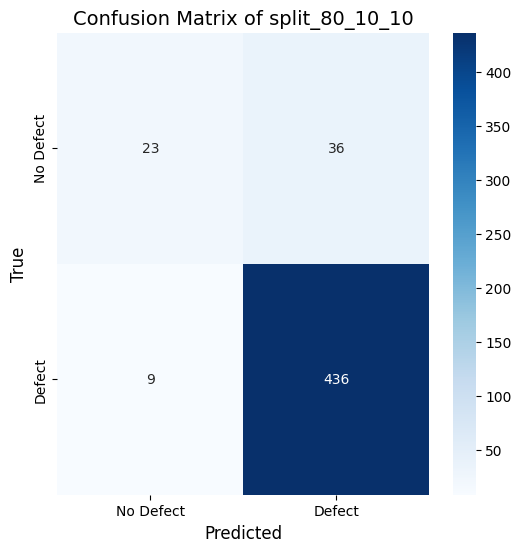

In [23]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

save_dir = r"C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\split_80_10_10"
os.makedirs(save_dir, exist_ok=True)

test_steps = test_generator_80_10_10.samples // test_generator_80_10_10.batch_size  
y_true = []
y_pred = []

# get prediction result
for _ in range(test_steps):
    x, y = test_generator_80_10_10.next()
    predictions = model.predict(x)
    
    # get true label
    y_true.extend(np.argmax(y, axis=1)) 
    # get prediction label
    y_pred.extend(np.argmax(predictions, axis=1))


# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate sensitivity (Recall) and specificity
TP = cm[1, 1] 
TN = cm[0, 0]  
FP = cm[0, 1]  
FN = cm[1, 0]  

sensitivity = TP / float(TP + FN)
specificity = TN / float(TN + FP)

print(f'Sensitivity (Recall): {sensitivity}')
print(f'Specificity: {specificity}')

# Plot the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Defect', 'Defect'], yticklabels=['No Defect', 'Defect'])
plt.title('Confusion Matrix of split_80_10_10', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

# Save the confusion matrix plot
confusion_matrix_path = os.path.join(save_dir, 'confusion_matrix_split_80_10_10.png')
plt.savefig(confusion_matrix_path, dpi=600, bbox_inches='tight')

# Print the saved path
print(f"Confusion matrix saved at: {confusion_matrix_path}")

# Show the plot
plt.show()


In [25]:
from sklearn.metrics import f1_score
import numpy as np

test_steps = test_generator_80_10_10.samples // test_generator_80_10_10.batch_size
y_true = []
y_pred = []

for _ in range(test_steps):
    x, y = test_generator_80_10_10.next()
    predictions = model.predict(x)
    y_true.extend(np.argmax(y, axis=1))              
    y_pred.extend(np.argmax(predictions, axis=1))   

f1 = f1_score(y_true, y_pred, average='binary')  
print(f'F1 Score: {f1:.4f}')

1/1 [==============================] - 0s 69ms/step
F1 Score: 0.9540


1/1 [==============================] - 0s 69ms/step
Precision_Recall Curve saved at: C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\split_80_10_10\precision-recall_curve_split_80_10_10.png


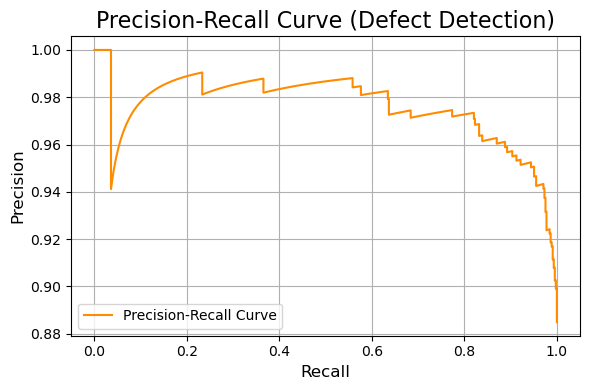

In [26]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
import os

save_dir = r"C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\split_80_10_10"
os.makedirs(save_dir, exist_ok=True)

test_steps = test_generator_80_10_10.samples // test_generator_80_10_10.batch_size

y_true = []
y_scores = []

for _ in range(test_steps):
    x_batch, y_batch = test_generator_80_10_10.next()
    preds = model.predict(x_batch)

    y_true.extend(np.argmax(y_batch, axis=1))
    
    y_scores.extend(preds[:, 1])

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label='Precision-Recall Curve', color='darkorange')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve (Defect Detection)', fontsize=16)
plt.legend(loc="lower left")
plt.grid(True)

# Corrected variable name
precision_recall_curve_path = os.path.join(save_dir, 'precision-recall_curve_split_80_10_10.png')
plt.savefig(precision_recall_curve_path, dpi=600, bbox_inches='tight')
print(f"Precision_Recall Curve saved at: {precision_recall_curve_path}")

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 67ms/step
ROC Curve saved at: C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\split_80_10_10\roc_curve_split_80_10_10.png


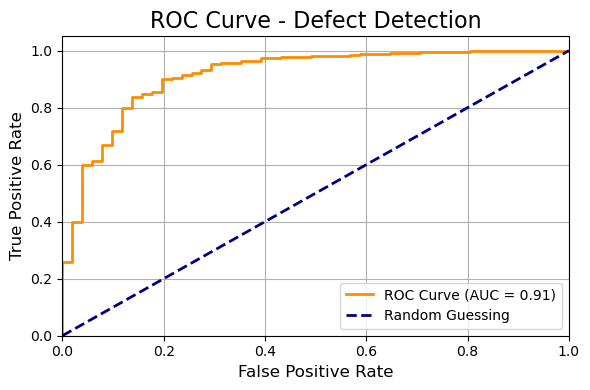

In [27]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

save_dir = r"C:\Users\xiaog\Desktop\Project\Datasets\dataset\Performance\split_80_10_10"
os.makedirs(save_dir, exist_ok=True)

test_steps = test_generator_80_10_10.samples // test_generator_80_10_10.batch_size

y_true = []
y_scores = []

for _ in range(test_steps):
    x_batch, y_batch = test_generator_80_10_10.next()
    preds = model.predict(x_batch)

    y_true.extend(np.argmax(y_batch, axis=1))

    y_scores.extend(preds[:, 1])

# calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guessing')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Defect Detection', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)

ROC_Curve_path = os.path.join(save_dir, 'roc_curve_split_80_10_10.png')
plt.savefig(confusion_matrix_path, dpi=600, bbox_inches='tight')
print(f"ROC Curve saved at: {ROC_Curve_path}")

plt.tight_layout()
plt.show()

In [26]:
for layer in model.layers[::-1]:  
    if 'conv' in layer.name:
        print("The last layer:", layer.name)
        break

The last layer: conv2d_35


1/1 [==============================] - 2s 2s/step
Predicted probabilities: [[0.0995064 0.9004936]]
Predicted class: defective


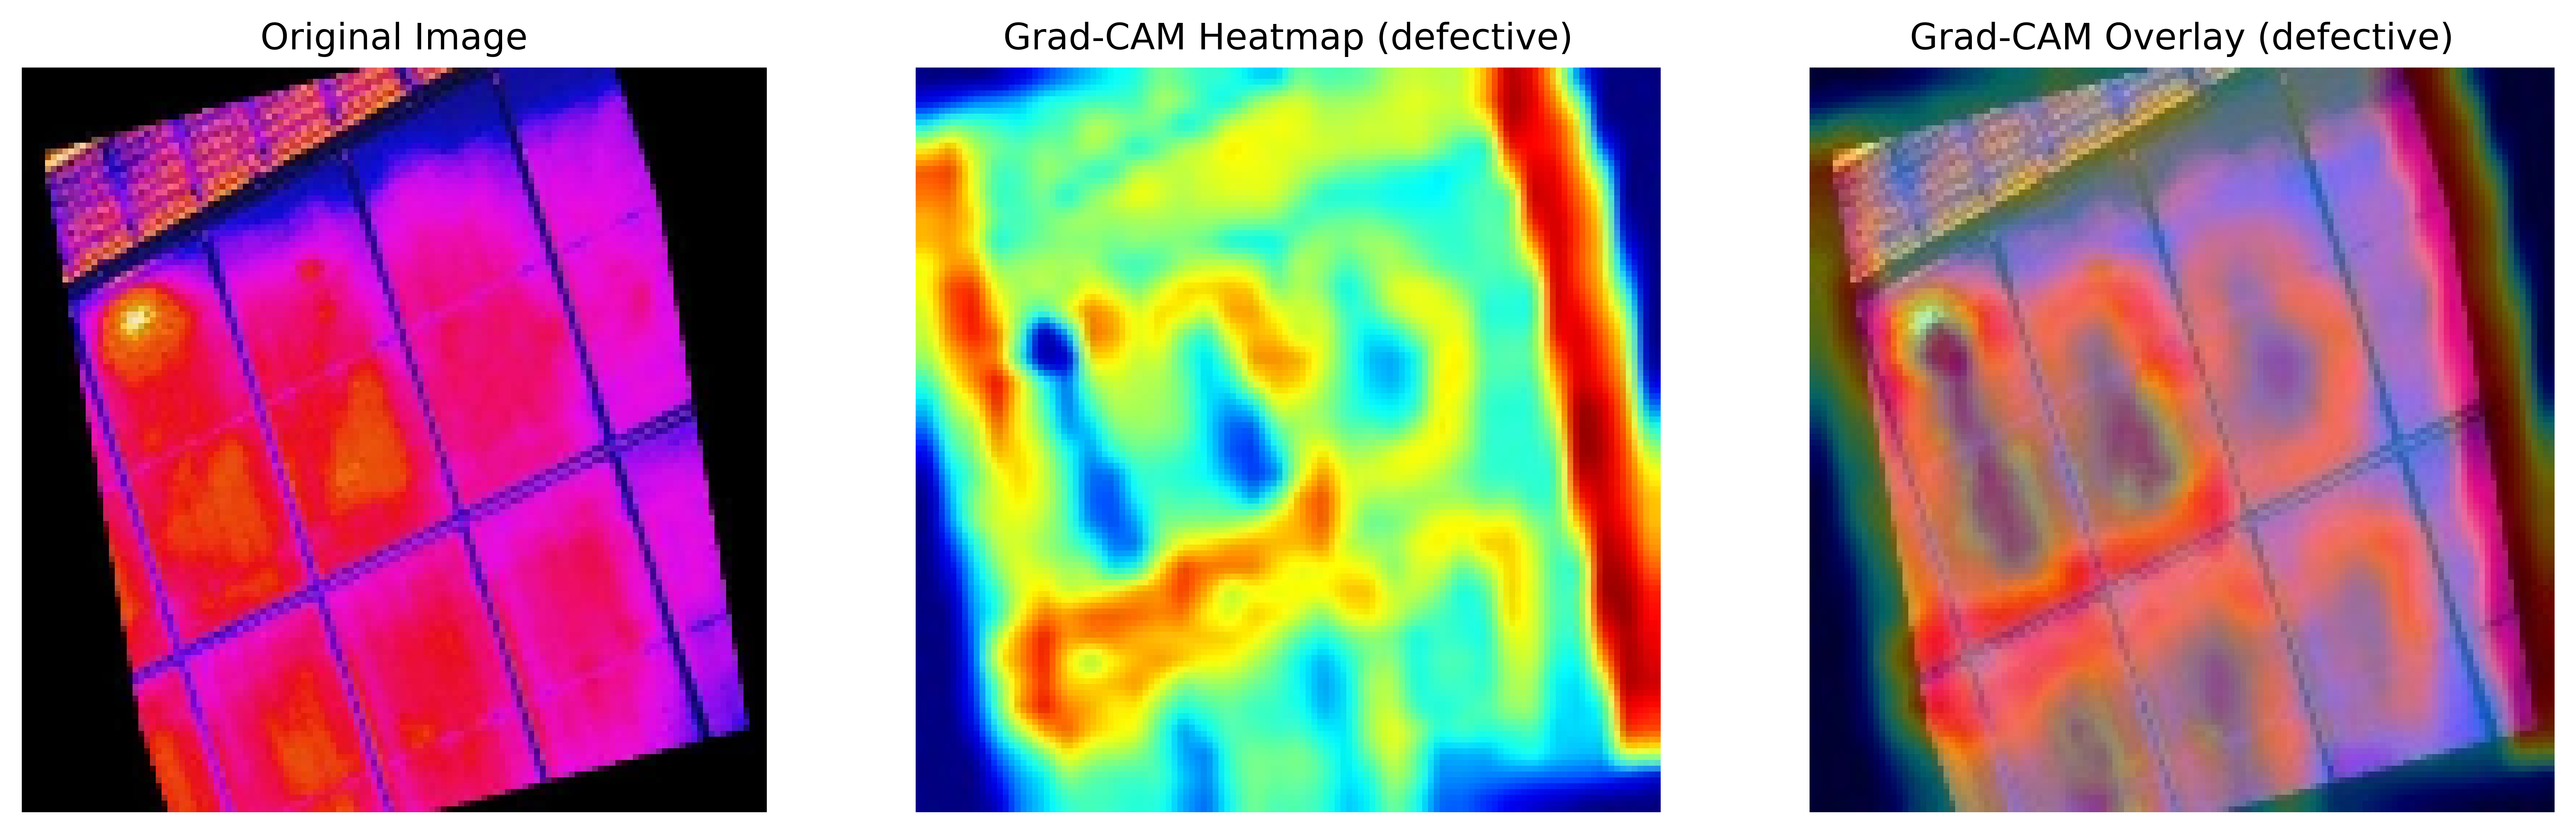

Combined Grad-CAM image saved to: C:/Users/xiaog/Desktop/Project/Datasets/dataset/Performance/XAI/Grad-CAM/combined_test_0270_defective.jpg


In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
import os

def get_img_array(img_path, size=(128, 128)):
    img = image.load_img(img_path, target_size=size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=1):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_gradcam_only(heatmap, save_path, size=(128, 128), colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, size)
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)
    cv2.imwrite(save_path, heatmap_color)

def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.4, size=(128, 128)):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at: {img_path}")
    img = cv2.resize(img, size)
    
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    cv2.imwrite(cam_path, superimposed_img)

# Load model
model = tf.keras.models.load_model(
    'models/best_model_split_80_10_10.h5', 
    custom_objects={'focal_loss_fixed': focal_loss(gamma=2., alpha=0.75)}
)

# Target image path
img_path = r"C:/Users/xiaog/Desktop/Project/Datasets/dataset/split_80_10_10/test/images/test_0270.jpg"
img_array = get_img_array(img_path)

# Get predictions for the image
predictions = model.predict(img_array)
print(f"Predicted probabilities: {predictions}")

# Now, based on your description, "1" is defective (with defect), and "0" is non-defective (without defect)
pred_index = 1 if predictions[0][1] > predictions[0][0] else 0

# Dynamically get the predicted class name
class_names = ['non_defective', 'defective']  # Define your class names
predicted_class = class_names[pred_index]  # Use pred_index to get the predicted class name

print(f"Predicted class: {predicted_class}")

# Generate the Grad-CAM heatmap for the correct class
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='conv2d_35', pred_index=pred_index)

# Save Grad-CAM heatmap (not overlaid)
img_name = os.path.basename(img_path).split('.')[0]
heatmap_path = f"C:/Users/xiaog/Desktop/Project/Datasets/dataset/Performance/XAI/Grad-CAM/heatmap_{img_name}_{predicted_class}.jpg"
save_gradcam_only(heatmap, heatmap_path)

# Save Grad-CAM overlay (superimposed image)
cam_path = f"C:/Users/xiaog/Desktop/Project/Datasets/dataset/Performance/XAI/Grad-CAM/cam_{img_name}_{predicted_class}.jpg"
save_and_display_gradcam(img_path, heatmap, cam_path)

# Display all three images side by side and save as one image
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img = cv2.resize(original_img, (128, 128))

gradcam_img = cv2.imread(cam_path)
gradcam_img = cv2.cvtColor(gradcam_img, cv2.COLOR_BGR2RGB)

heatmap_img = cv2.imread(heatmap_path)
heatmap_img = cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB)

# Create a single figure to display all three images side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=600)

axes[0].imshow(original_img)
axes[0].set_title("Original Image", fontsize=12)
axes[0].axis("off")

axes[1].imshow(heatmap_img)
axes[1].set_title(f"Grad-CAM Heatmap ({predicted_class})", fontsize=12)
axes[1].axis("off")

axes[2].imshow(gradcam_img)
axes[2].set_title(f"Grad-CAM Overlay ({predicted_class})", fontsize=12)
axes[2].axis("off")

# Adjust layout to avoid title clipping
plt.subplots_adjust(wspace=0.2)

# Save the combined image
combined_image_path = f"C:/Users/xiaog/Desktop/Project/Datasets/dataset/Performance/XAI/Grad-CAM/combined_{img_name}_{predicted_class}.jpg"
fig.savefig(combined_image_path, dpi=600)

# Display the combined image
plt.show()

print(f"Combined Grad-CAM image saved to: {combined_image_path}")
